## Land Use Land Cover Segmentation

In [ ]:
"""
Author: Gustave-MB
"""

In [ ]:
!pip install torchgeo imagecodecs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.5/292.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 123.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
# ML utils & data manipulation
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, models

# Dataset
from torchgeo.datasets import LandCoverAI

import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import rasterio as rio
from rasterio.merge import merge
from glob import glob
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

#Google Drive
from google.colab import drive

### Device and torch version

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
print("PyTorch version:", torch.__version__)

Device: cuda
PyTorch version: 2.0.1+cu118


### Dataset

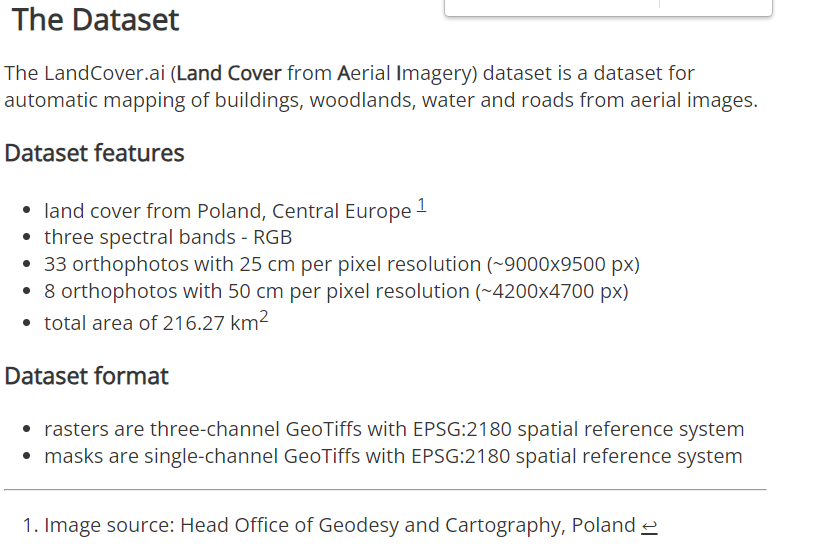
https://landcover.ai.linuxpolska.com/
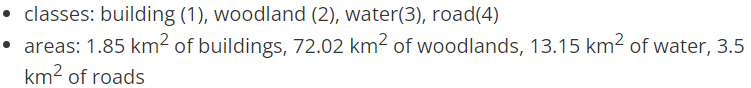

### Transforms

In [ ]:
def train_transform(sample):
  image_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
                    [0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225]
                             ),
        ])

  target_transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize(224),
      transforms.ToTensor(),
  ])

  return {'image': image_transform(sample['image'].type(torch.uint8)).to(device),
          'mask': torch.squeeze(target_transform(sample['mask'].type(torch.uint8)).to(device),0)*255}



### Download data

In [ ]:
%%time

training_dataset = LandCoverAI(root="./land_cover_data",split='train', download=True, checksum=True, transforms=train_transform)
len(training_dataset)

CPU times: user 102 ms, sys: 11.5 ms, total: 113 ms
Wall time: 119 ms


7470

In [ ]:
%%time

validation_dataset = LandCoverAI(root="./land_cover_data",split='val', download=True, checksum=True, transforms=train_transform)
len(validation_dataset)

CPU times: user 81.6 ms, sys: 20.9 ms, total: 103 ms
Wall time: 105 ms


1602

In [ ]:
%%time

testing_dataset = LandCoverAI(root="./land_cover_data",split='test', download=True, checksum=True, transforms=train_transform)
len(testing_dataset)

CPU times: user 91.7 ms, sys: 16 ms, total: 108 ms
Wall time: 113 ms


1602

 ## Data check

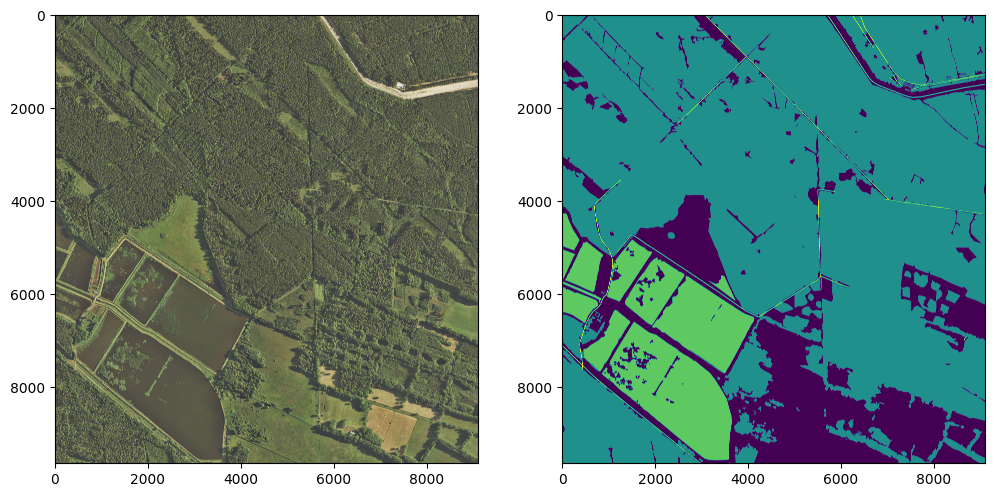

In [ ]:
image1 = 'land_cover_data/images/M-33-20-D-c-4-2.tif'
mask1 = 'land_cover_data/masks/M-33-20-D-c-4-2.tif'
fig, ax = plt.subplots(1,2, figsize=(12,10))
ax[0].imshow(cv2.cvtColor(cv2.imread(image1),cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.imread(mask1,0))
plt.show()


In [ ]:
with rio.open(image1) as dst:
  print(dst.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 9095, 'height': 9636, 'count': 3, 'crs': CRS.from_wkt('PROJCS["Projection: Transverse Mercator; Datum: WGS84; Ellipsoid: WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",19],PARAMETER["scale_factor",0.9993],PARAMETER["false_easting",500000],PARAMETER["false_northing",-5300000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(0.25, 0.0, 280307.7499987148,
       0.0, -0.25, 394546.9999900842)}


In [ ]:
with rio.open(mask1) as dst:
  print(dst.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 9095, 'height': 9636, 'count': 1, 'crs': CRS.from_wkt('PROJCS["Projection: Transverse Mercator; Datum: WGS84; Ellipsoid: WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",19],PARAMETER["scale_factor",0.9993],PARAMETER["false_easting",500000],PARAMETER["false_northing",-5300000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(0.25, 0.0, 280307.7499987148,
       0.0, -0.25, 394546.9999900842)}


### Display sample image and its mask

##### Inverse normalization

In [ ]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)


Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([224, 224])


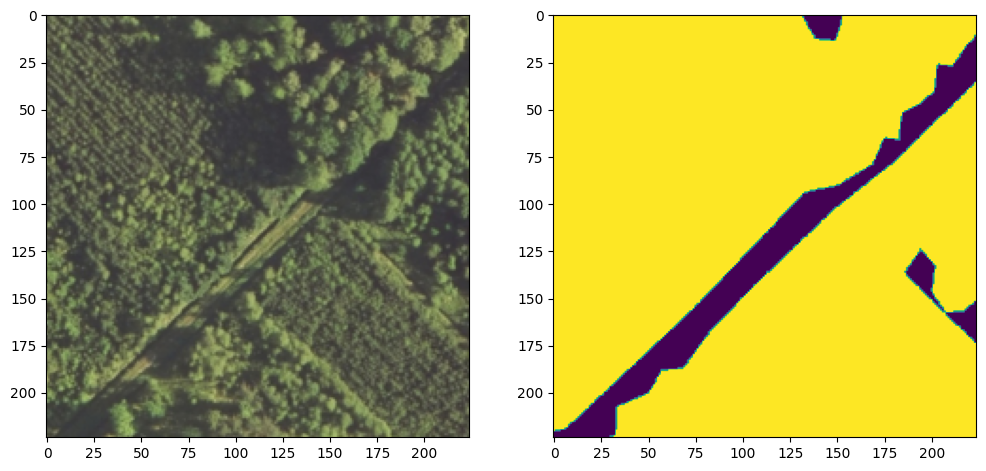

In [ ]:
for data in training_dataset:
    x, y = data["image"], data["mask"]
    print(f'Image shape: {x.shape}\nMask shape: {y.shape}')
    fig, ax = plt.subplots(1,2, figsize=(12,10))
    ax[0].imshow(inv_normalize(x.cpu()).permute(1, 2, 0))
    ax[1].imshow(y.cpu())
    break

## Dataloaders

In [ ]:
torch.manual_seed(2023) # For reproducibility

In [ ]:
train_dloader    = DataLoader(
                        training_dataset,
                        batch_size=32,
                        shuffle=True
                        )
val_dloader      = DataLoader(
                        validation_dataset,
                        batch_size=8,
                        shuffle=False
                        )

### Util functions


##### Merging image tiles

In [ ]:
def merge_files(files):

    rasters = [ rio.open(f) for f in files ]
    mosaic, trans = merge(rasters)

    # Get metadata from the first raster
    meta = rasters[0].meta.copy()

    # Update metadata with mosaic shape and transform
    meta.update({
        'height': mosaic.shape[1],
        'width': mosaic.shape[2],
        'transform': trans
    })

    # Close all opened rasters
    for raster in rasters:
        raster.close()

    return mosaic, meta


In [ ]:
def save_merged(mosaic, meta, out_path):

    with rio.open(out_path, 'w', **meta) as dst:
        dst.write(mosaic)


In [ ]:
def create_image_from_patches(patches_path, out_path):
    """
    This function creates image from image patches

    Parameters:
        - patches_path: String => Directory path where your georeferenced patches are stored
        - out_path: String => full path where you want to write your merged image, this should be a .tif

    Return: Does not return anything
    """
    patches_names = glob(os.path.join(patches_path,"*.tif"))
    mosaic, meta = merge_files(patches_names)
    save_merged(mosaic=mosaic, meta=meta, out_path=out_path)

##### Visualization

In [ ]:
def display_image(image, title, subplot_nb, cmap=None):
  plt.subplot(subplot_nb)
  plt.imshow(image, cmap=cmap)
  plt.title(title)
  plt.axis("off")

In [ ]:
def scale_gray_values(mask):
  mask[mask==1]=60
  mask[mask==2]=120
  mask[mask==3]=180
  mask[mask==4]=255
  return mask

In [ ]:
def mask_legend(grayscale_values = [0, 60, 120, 180, 255]):
  """
  Create a legend image
  """
  labels = ['Background', 'Building', 'Woodland', 'Water', 'Road']
  legend_img = np.tile(grayscale_values, (len(grayscale_values), 1)).T
  plt.subplot(144)
  plt.imshow(legend_img, cmap='gray')
  plt.yticks(np.arange(len(labels)), labels)
  plt.xticks([])
  plt.ylabel('Classes')
  plt.title('Color code')

##### Building model

In [ ]:
def resnet_backbone(name, pretrained):
  try:
    if name == 'resnet18':
        backbone = models.resnet18(pretrained=pretrained)
    elif name == 'resnet34':
          backbone = models.resnet34(pretrained=pretrained)
    return backbone
  except:
    print(f'{name} not found!\n backbone must be resnet18 or resnet34')

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(f'Model total parameters: {sum(params):>6}')


In [ ]:
def upconv(ch_in, ch_out, kernel_size=(3, 3),stride=1, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels=ch_in, out_channels=ch_out, kernel_size=(3, 3),
                               stride=stride, padding=padding),
      nn.ReLU(inplace=True),
  )


### Building model

##### Model architecture

In [ ]:
class Unet_resnet(nn.Module):

    def __init__(self, n_class,
                 pretrained=True,
                 encoder_freeze=False
                 ):
        super().__init__()

        # Encoder
        self.backbone = models.resnet34(pretrained=pretrained)
        self.layer0 = nn.Sequential(*list(self.backbone.children())[:3])
        self.layer1 = nn.Sequential(*list(self.backbone.children())[3:5])
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3
        self.layer4 = self.backbone.layer4

        # Decoder
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up3 = upconv(768, 512, 3, 1) # 256 + 512, 512
        self.conv_up2 = upconv(640, 256, 3, 1) # 128 + 512, 256
        self.conv_up1 = upconv(320, 256, 3, 1)  # 64 + 256, 256
        self.conv_up0 = upconv(320, 128, 3, 1)  # 64 + 256, 128

        self.conv_original_size0 = upconv(3, 64, 3, 1)
        self.conv_original_size1 = upconv(64, 64, 3, 1)
        self.conv_original_size2 = upconv(192, 64, 3, 1) # 64 + 128, 64
        self.final_conv = nn.Conv2d(64, n_class, 1)


    def freeze_encoder(self):

        """ Freezing encoder parameters"""

        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, input):

      x_original = self.conv_original_size0(input)
      x_original = self.conv_original_size1(x_original)

      if encoder_freeze:  # Freze backbone weights if True
          self.freeze_encoder()

      layer0 = self.layer0(input)
      layer1 = self.layer1(layer0)
      layer2 = self.layer2(layer1)
      layer3 = self.layer3(layer2)
      layer4 = self.layer4(layer3)

      x = self.upsample(layer4)
      x = torch.cat([x, layer3], dim=1)
      x = self.conv_up3(x)

      x = self.upsample(x)
      x = torch.cat([x, layer2], dim=1)
      x = self.conv_up2(x)

      x = self.upsample(x)
      x = torch.cat([x, layer1], dim=1)
      x = self.conv_up1(x)

      x = self.upsample(x)
      x = torch.cat([x, layer0], dim=1)
      x = self.conv_up0(x)

      x = self.upsample(x)
      x = torch.cat([x, x_original], dim=1)
      x = self.conv_original_size2(x)

      out = self.final_conv(x)

      return out


##### Loss function

In [ ]:
n_class=5

In [ ]:
ce = nn.CrossEntropyLoss()

def cEntropy_Loss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc


### Model Training and evaluation

In [ ]:
model = Unet_resnet(n_class=n_class).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 58.9MB/s]


In [ ]:
# Total number of parameters in the model
count_parameters(model)

Model total parameters: 28067949


In [ ]:
# Training and validation losses and accuracy
train_loss_avg = []
val_loss_avg = []

train_acc_avg = []
val_acc_avg = []


       Epoch: 0   
   ******************   


 93%|█████████▎| 150/161 [00:41<00:02,  3.95it/s]

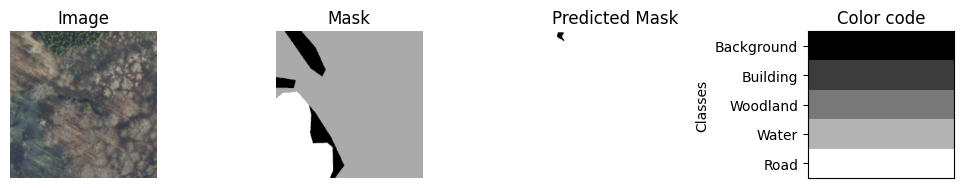

100%|██████████| 161/161 [00:44<00:00,  3.62it/s]


Train loss: 0.4288	Train acc: 0.8535	Val loss: 0.2233	Val acc: 0.9241

       Epoch: 1   
   ******************   


 12%|█▏        | 19/161 [00:05<00:36,  3.84it/s]

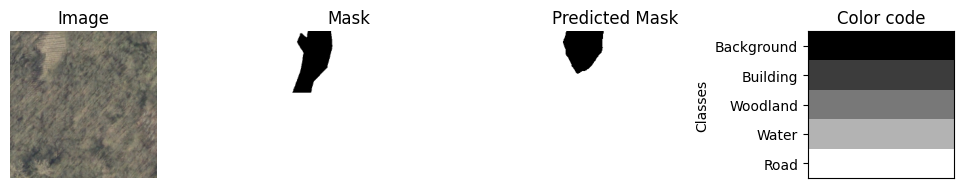

100%|██████████| 161/161 [00:44<00:00,  3.59it/s]


Train loss: 0.2603	Train acc: 0.9113	Val loss: 0.2039	Val acc: 0.9303

       Epoch: 2   
   ******************   


 86%|████████▋ | 139/161 [00:39<00:05,  4.03it/s]

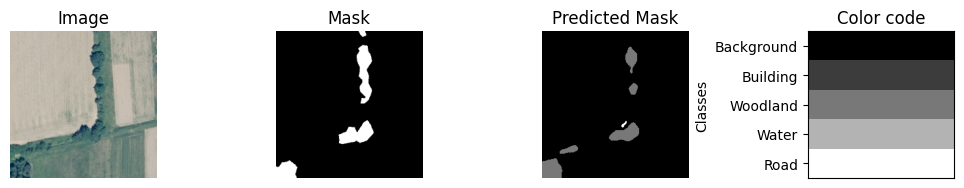

100%|██████████| 161/161 [00:44<00:00,  3.59it/s]


Train loss: 0.2243	Train acc: 0.9232	Val loss: 0.1956	Val acc: 0.9319

       Epoch: 3   
   ******************   


 24%|██▎       | 38/161 [00:11<00:41,  2.99it/s]

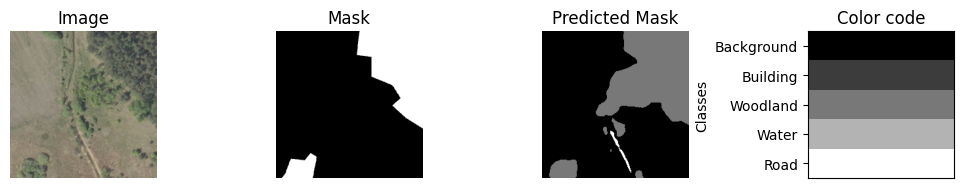

100%|██████████| 161/161 [00:51<00:00,  3.14it/s]


Train loss: 0.1875	Train acc: 0.9359	Val loss: 0.1883	Val acc: 0.9356

       Epoch: 4   
   ******************   


 43%|████▎     | 70/161 [00:23<00:34,  2.61it/s]

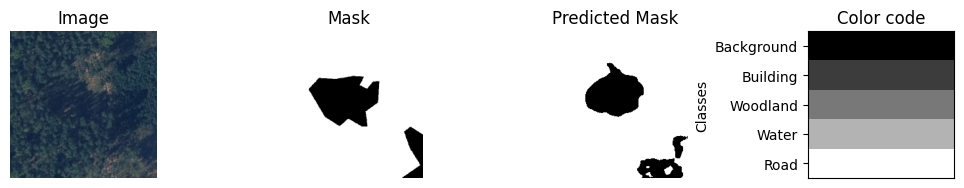

100%|██████████| 161/161 [00:49<00:00,  3.25it/s]


Train loss: 0.1715	Train acc: 0.9412	Val loss: 0.1801	Val acc: 0.9381

       Epoch: 5   
   ******************   


 76%|███████▋  | 123/161 [00:33<00:10,  3.77it/s]

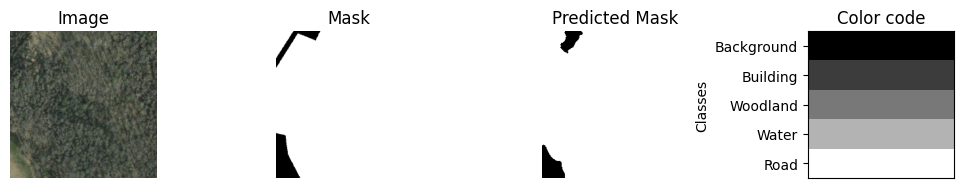

100%|██████████| 161/161 [00:43<00:00,  3.68it/s]


Train loss: 0.1624	Train acc: 0.9448	Val loss: 0.1811	Val acc: 0.9392

       Epoch: 6   
   ******************   


 63%|██████▎   | 102/161 [00:28<00:18,  3.15it/s]

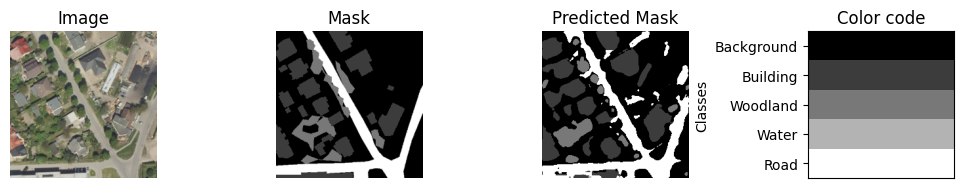

100%|██████████| 161/161 [00:44<00:00,  3.58it/s]


Train loss: 0.1570	Train acc: 0.9463	Val loss: 0.1812	Val acc: 0.9394

       Epoch: 7   
   ******************   


 35%|███▍      | 56/161 [00:15<00:27,  3.84it/s]

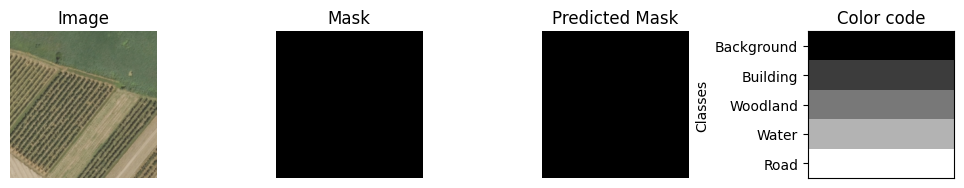

100%|██████████| 161/161 [00:45<00:00,  3.55it/s]


Train loss: 0.1389	Train acc: 0.9523	Val loss: 0.1775	Val acc: 0.9412

       Epoch: 8   
   ******************   


 27%|██▋       | 44/161 [00:12<00:30,  3.89it/s]

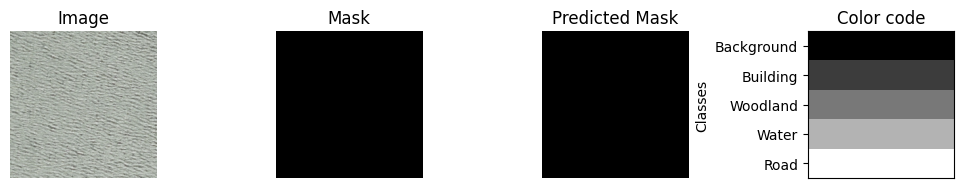

100%|██████████| 161/161 [00:45<00:00,  3.57it/s]


Train loss: 0.1301	Train acc: 0.9552	Val loss: 0.1818	Val acc: 0.9407

       Epoch: 9   
   ******************   


 10%|▉         | 16/161 [00:05<00:41,  3.46it/s]

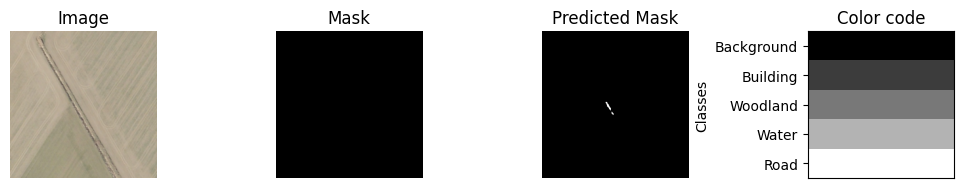

100%|██████████| 161/161 [00:44<00:00,  3.59it/s]


Train loss: 0.1259	Train acc: 0.9565	Val loss: 0.1789	Val acc: 0.9391

       Epoch: 10   
   ******************   


  2%|▏         | 4/161 [00:01<00:51,  3.03it/s]

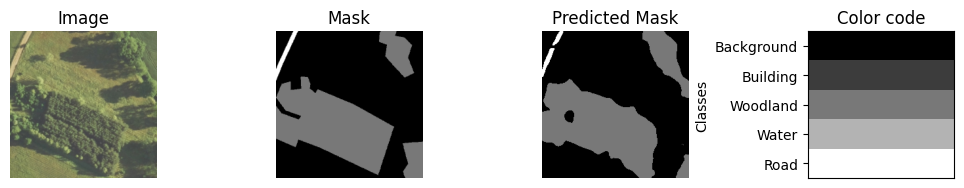

100%|██████████| 161/161 [00:44<00:00,  3.60it/s]


Train loss: 0.1620	Train acc: 0.9450	Val loss: 0.1762	Val acc: 0.9407

       Epoch: 11   
   ******************   


 90%|█████████ | 145/161 [00:40<00:04,  3.94it/s]

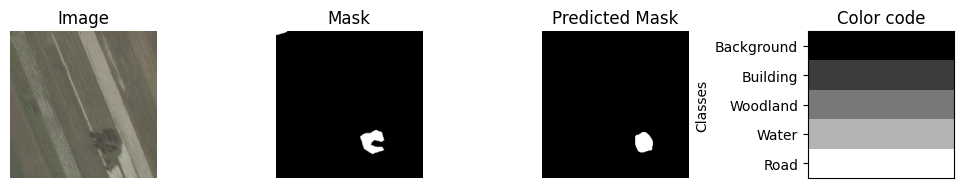

100%|██████████| 161/161 [00:45<00:00,  3.56it/s]


Train loss: 0.1293	Train acc: 0.9555	Val loss: 0.1735	Val acc: 0.9436

       Epoch: 12   
   ******************   


  6%|▌         | 10/161 [00:03<00:50,  2.98it/s]

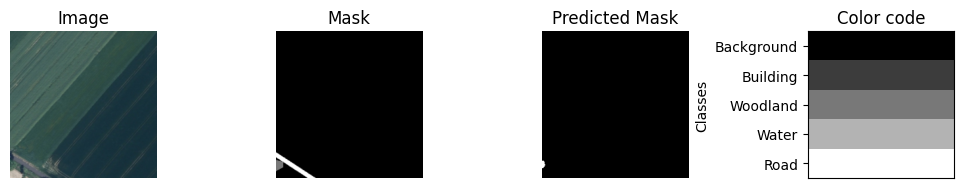

100%|██████████| 161/161 [00:45<00:00,  3.51it/s]


Train loss: 0.1187	Train acc: 0.9590	Val loss: 0.3321	Val acc: 0.8854

       Epoch: 13   
   ******************   


 48%|████▊     | 78/161 [00:23<00:23,  3.50it/s]

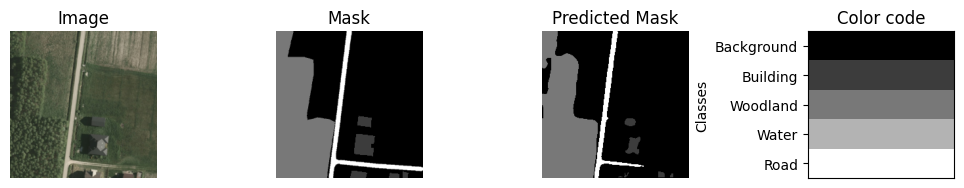

100%|██████████| 161/161 [00:45<00:00,  3.50it/s]


Train loss: 0.1256	Train acc: 0.9574	Val loss: 0.1875	Val acc: 0.9403

       Epoch: 14   
   ******************   


 57%|█████▋    | 92/161 [00:25<00:22,  3.11it/s]

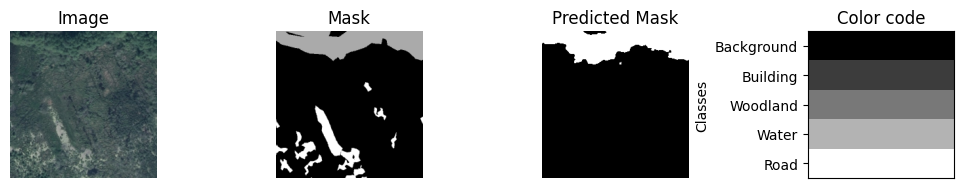

100%|██████████| 161/161 [00:45<00:00,  3.57it/s]


Train loss: 0.1447	Train acc: 0.9508	Val loss: 0.1880	Val acc: 0.9384

       Epoch: 15   
   ******************   


 76%|███████▋  | 123/161 [00:34<00:09,  3.93it/s]

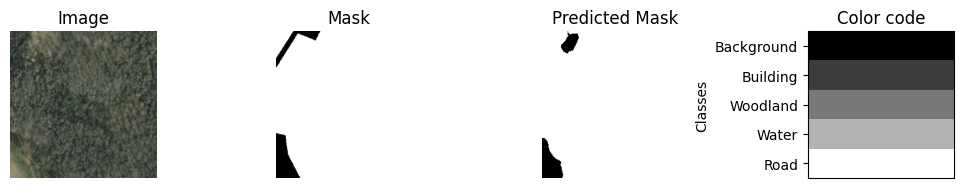

100%|██████████| 161/161 [00:45<00:00,  3.57it/s]


Train loss: 0.1234	Train acc: 0.9575	Val loss: 0.1824	Val acc: 0.9427

       Epoch: 16   
   ******************   


 29%|██▊       | 46/161 [00:13<00:30,  3.83it/s]

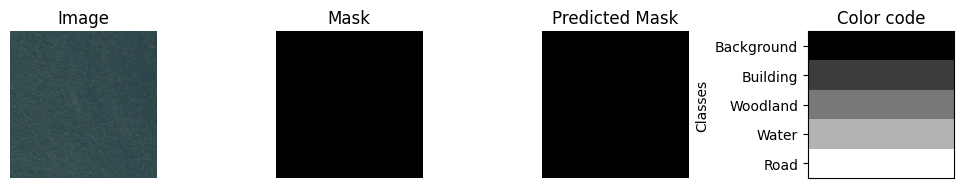

100%|██████████| 161/161 [00:45<00:00,  3.55it/s]


Train loss: 0.1150	Train acc: 0.9603	Val loss: 0.1838	Val acc: 0.9448

       Epoch: 17   
   ******************   


 93%|█████████▎| 150/161 [00:42<00:02,  3.95it/s]

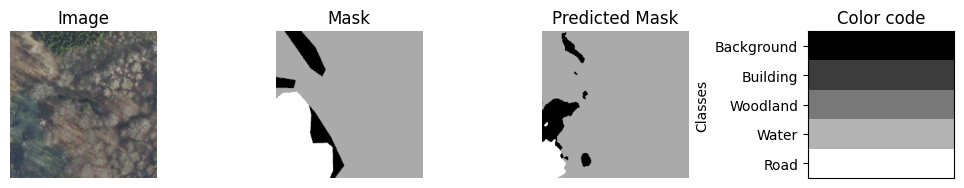

100%|██████████| 161/161 [00:45<00:00,  3.52it/s]


Train loss: 0.1019	Train acc: 0.9645	Val loss: 0.1850	Val acc: 0.9440

       Epoch: 18   
   ******************   


 27%|██▋       | 44/161 [00:12<00:37,  3.09it/s]

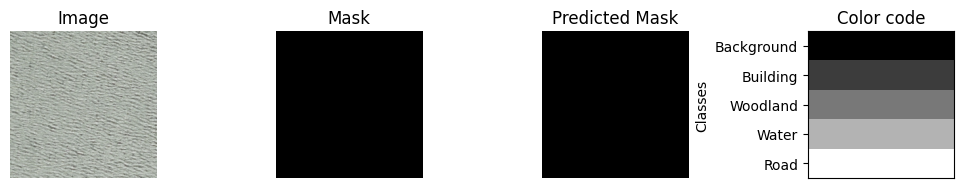

100%|██████████| 161/161 [00:45<00:00,  3.56it/s]


Train loss: 0.0951	Train acc: 0.9667	Val loss: 0.1896	Val acc: 0.9443

       Epoch: 19   
   ******************   


 76%|███████▋  | 123/161 [00:35<00:13,  2.73it/s]

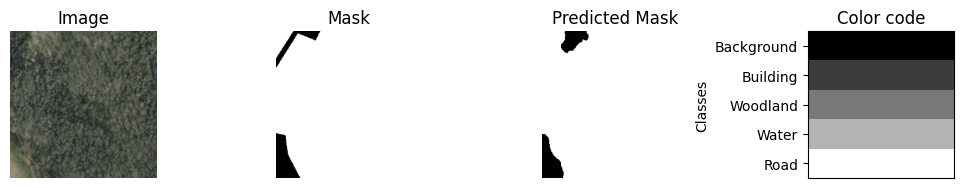

100%|██████████| 161/161 [00:46<00:00,  3.48it/s]


Train loss: 0.0914	Train acc: 0.9680	Val loss: 0.1890	Val acc: 0.9451

       Epoch: 20   
   ******************   


 96%|█████████▋| 155/161 [00:42<00:01,  3.88it/s]

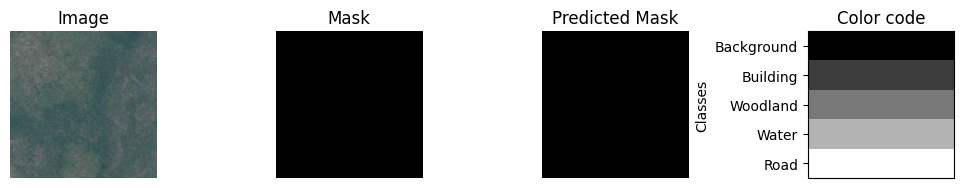

100%|██████████| 161/161 [00:44<00:00,  3.61it/s]


Train loss: 0.0895	Train acc: 0.9686	Val loss: 0.2021	Val acc: 0.9440

       Epoch: 21   
   ******************   


 88%|████████▊ | 141/161 [00:38<00:05,  3.98it/s]

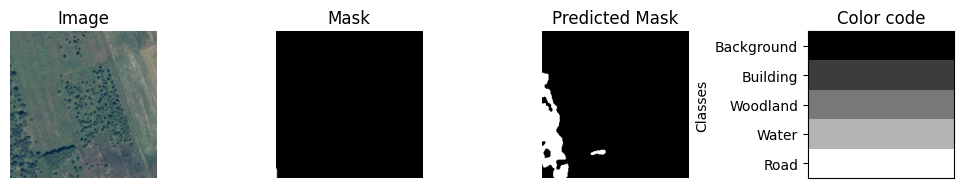

100%|██████████| 161/161 [00:44<00:00,  3.59it/s]


Train loss: 0.0870	Train acc: 0.9695	Val loss: 0.1994	Val acc: 0.9446

       Epoch: 22   
   ******************   


 96%|█████████▌| 154/161 [00:43<00:01,  3.86it/s]

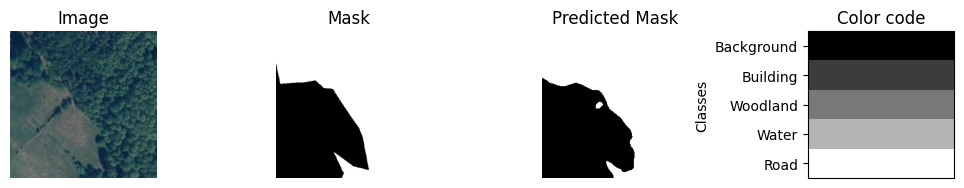

100%|██████████| 161/161 [00:45<00:00,  3.56it/s]


Train loss: 0.0853	Train acc: 0.9701	Val loss: 0.2096	Val acc: 0.9447

       Epoch: 23   
   ******************   


 86%|████████▋ | 139/161 [00:39<00:05,  3.97it/s]

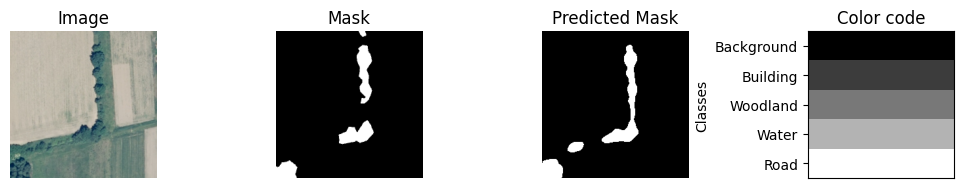

100%|██████████| 161/161 [00:45<00:00,  3.54it/s]


Train loss: 0.0833	Train acc: 0.9707	Val loss: 0.1974	Val acc: 0.9443

       Epoch: 24   
   ******************   


 22%|██▏       | 35/161 [00:09<00:39,  3.16it/s]

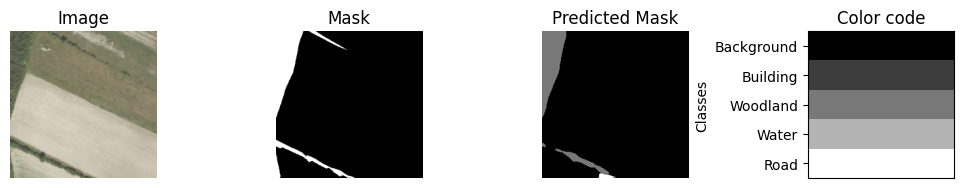

100%|██████████| 161/161 [00:45<00:00,  3.53it/s]


Train loss: 0.0813	Train acc: 0.9714	Val loss: 0.2855	Val acc: 0.9150

       Epoch: 25   
   ******************   


 60%|██████    | 97/161 [00:27<00:16,  3.85it/s]

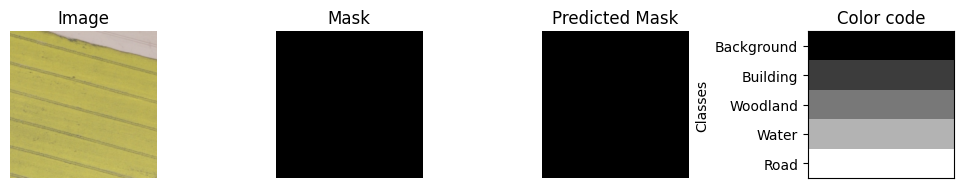

100%|██████████| 161/161 [00:46<00:00,  3.49it/s]


Train loss: 0.0870	Train acc: 0.9698	Val loss: 0.1862	Val acc: 0.9439

       Epoch: 26   
   ******************   


  7%|▋         | 11/161 [00:03<00:39,  3.80it/s]

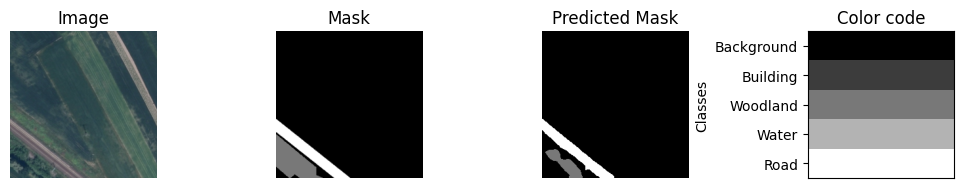

100%|██████████| 161/161 [00:45<00:00,  3.51it/s]


Train loss: 0.1220	Train acc: 0.9587	Val loss: 0.1925	Val acc: 0.9449

       Epoch: 27   
   ******************   


 47%|████▋     | 75/161 [00:21<00:22,  3.75it/s]

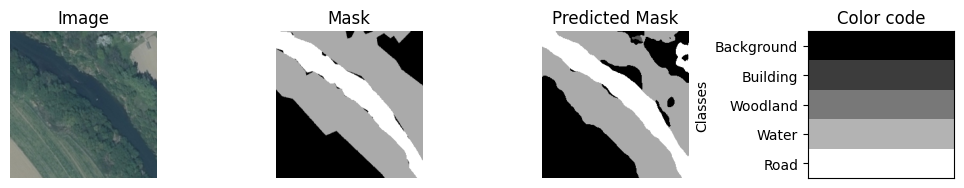

100%|██████████| 161/161 [00:46<00:00,  3.47it/s]


Train loss: 0.0892	Train acc: 0.9688	Val loss: 0.1998	Val acc: 0.9453

       Epoch: 28   
   ******************   


 45%|████▍     | 72/161 [00:21<00:23,  3.77it/s]

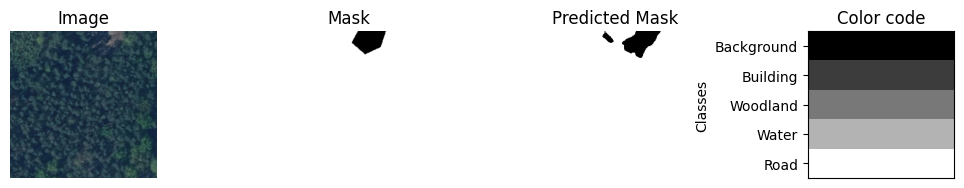

100%|██████████| 161/161 [00:47<00:00,  3.37it/s]


Train loss: 0.0784	Train acc: 0.9725	Val loss: 0.2022	Val acc: 0.9396

       Epoch: 29   
   ******************   


 42%|████▏     | 67/161 [00:19<00:31,  3.00it/s]

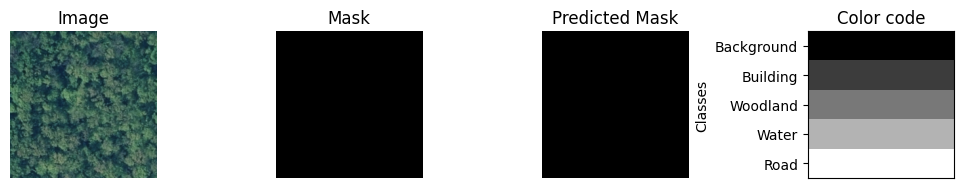

100%|██████████| 161/161 [00:46<00:00,  3.46it/s]

Train loss: 0.0877	Train acc: 0.9697	Val loss: 0.2018	Val acc: 0.9444

CPU times: user 2h 54min 41s, sys: 1min 4s, total: 2h 55min 45s
Wall time: 2h 58min 14s


In [ ]:
%%time
for epoch in range(30):
    print(f"       Epoch: {epoch}   \n   ******************   ")

    # Training
    model.train()
    train_losses = []
    train_accs = []
    for bx, data in tqdm(enumerate(train_dloader), total=len(train_dloader)):
        ims, ce_masks = data["image"].to(device),data["mask"].type(torch.LongTensor).to(device)
        pred_masks = model(ims)

        optimizer.zero_grad()
        loss, acc = cEntropy_Loss(pred_masks, ce_masks)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_accs.append(acc.item())

    train_loss_avg.append(np.mean(train_losses))
    train_acc_avg.append(np.mean(train_accs))

    # Validation
    model.eval()
    val_losses = []
    val_accs = []
    with torch.no_grad():
      rc_ = np.random.randint(len(val_dloader))
      for bx, data in tqdm(enumerate(val_dloader), total=len(val_dloader)):
          val_ims, val_masks = data["image"],data["mask"].type(torch.LongTensor).to(device)

          pred_masks = model(val_ims)
          loss, acc = cEntropy_Loss(pred_masks, val_masks)
          val_losses.append(loss.item())
          val_accs.append(acc.item())

          if bx == rc_:
              # Display an example image, mask, and predicted mask
              im = inv_normalize(val_ims[0]).permute(1, 2, 0).cpu().numpy()
              mask = val_masks[0].cpu().numpy()
              pred_mask = torch.argmax(pred_masks[0], dim=0).cpu().numpy()

              # Assign gray scale values to the classes
              mask = scale_gray_values(mask)
              pred_mask = scale_gray_values(pred_mask)

              # Display the image, mask, predicted mask
              plt.figure(figsize=(10, 10))
              display_image(image=im, title="Image", subplot_nb=141)
              display_image(image=mask, title="Mask", subplot_nb=142, cmap="gray")
              display_image(image=pred_mask, title="Predicted Mask", subplot_nb=143, cmap="gray")

              # Display the color code legend
              mask_legend()
              plt.tight_layout(pad=2.0, w_pad=0.5) # Adjust the spacing between subplots
              plt.show()

      val_loss_avg.append(np.mean(val_losses))
      val_acc_avg.append(np.mean(val_accs))

      print(f"Train loss: {train_loss_avg[epoch]:.4f}\tTrain acc: {train_acc_avg[epoch]:.4f}\tVal loss: {val_loss_avg[epoch]:.4f}\tVal acc: {val_acc_avg[epoch]:.4f}\n")

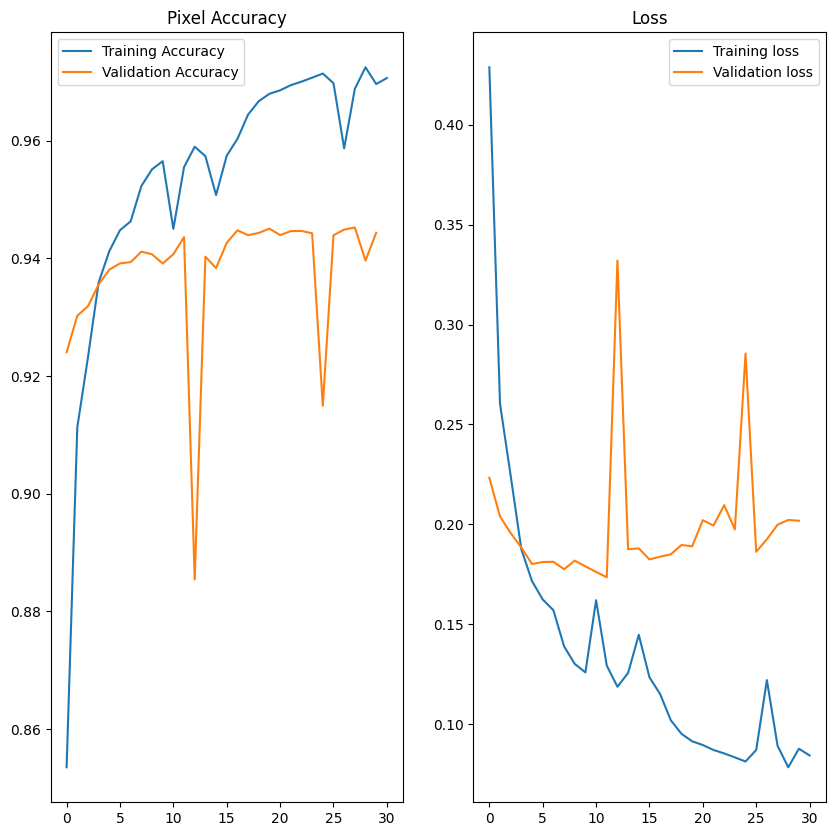

In [ ]:
plt.figure(figsize=(10, 10))
# Plot accuracy
plt.subplot(121)
plt.plot(train_acc_avg, label='Training Accuracy')
plt.plot(val_acc_avg, label='Validation Accuracy')
plt.title("Pixel Accuracy")
plt.legend()

# Plot the loss
plt.subplot(122)
plt.plot(train_loss_avg, label='Training loss')
plt.plot(val_loss_avg, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.show()

### Save the model

In [ ]:
drive.mount('/content/drive') # mount Google Drive to save model

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/models/Unet_resnet34_v2.pth'

In [ ]:
# Save model to Google Drive
torch.save(model.state_dict(), PATH)

### Load the model and evaluate on unseen images

In [ ]:
# Load model
Loaded_model = Unet_resnet(n_class=n_class,
                backbone_name='resnet34',
                pretrained=True,
                encoder_freeze=False).to(device)

In [ ]:
Loaded_model.load_state_dict(torch.load(PATH))
Loaded_model.eval()

In [ ]:
index = 800  # set image index not greater than 1602 to evaluate on test images

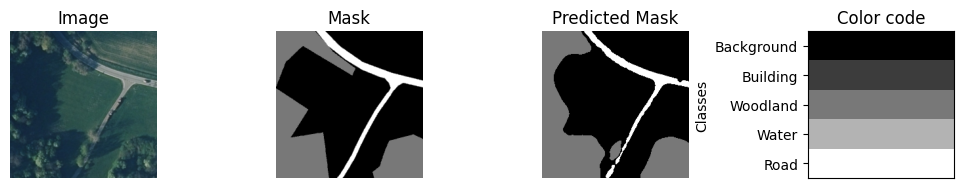

In [ ]:
with torch.no_grad():
  data = testing_dataset[index]
  val_ims, val_masks = data["image"].to(device),data["mask"].type(torch.LongTensor).to(device)
  pred_masks = Loaded_model(torch.unsqueeze(val_ims,0))

  # Display an example image, mask, and predicted mask
  im = inv_normalize(val_ims).permute(1, 2, 0).cpu().numpy()
  mask = val_masks.cpu().numpy()
  pred_mask = torch.argmax(pred_masks[0], dim=0).cpu().numpy()

  # Assign gray scale values to the classes
  mask = scale_gray_values(mask)
  pred_mask = scale_gray_values(pred_mask)

  # Display the image, mask, predicted mask
  plt.figure(figsize=(10, 10))
  display_image(image=im, title="Image", subplot_nb=141)
  display_image(image=mask, title="Mask", subplot_nb=142, cmap="gray")
  display_image(image=pred_mask, title="Predicted Mask", subplot_nb=143, cmap="gray")

  # Display the color code legend
  mask_legend()
  plt.tight_layout(pad=2.0, w_pad=0.5) # Adjust the spacing between subplots
  plt.show()


### Predict on custom image

In [ ]:
# Extract kigali dataset from the zip file on google drive
!unzip -q '/content/drive/MyDrive/Colab Notebooks/image_tiles.zip' -d '/content/image_tiles'

In [ ]:
# get each tile name
tile_names = glob(os.path.join('./image_tiles/image_tiles',"*.tif"))
# Number of tiles
len(tile_names)

15625

In [ ]:
# Transformation for normalizing and converting the image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
# Create directory to store predicted masks
!mkdir predictions

In [ ]:
# Prediction
with torch.no_grad():
    for image in tile_names:
        mask_name = image.split('/')[-1]
        image_ = cv2.imread(image)
        with rio.open(image) as tile:
            val_im = transform(image_).to(device)
            pred_mask_ = Loaded_model(torch.unsqueeze(val_im,0))
            pred_mask_ = torch.argmax(pred_mask_[0], dim=0).cpu().numpy()
            pred_mask_ = scale_gray_values(pred_mask_)

            with rio.Env():
                profile = tile.profile
                profile.update(
                    dtype=rio.uint8,
                    count=1,
                    compress='lzw')

                with rio.open(f'predictions/{mask_name}', 'w', **profile) as dst:
                    dst.write(pred_mask_.astype(rio.uint8), 1)



### Merge the masks

In [ ]:
# Set output path
output_folder_mergedTiles = '/content/drive/MyDrive/Colab Notebooks/merged_tiles'
out_path = os.path.join(output_folder_mergedTiles, 'predicted_mask_II.tif')

In [ ]:
# Merge and save the patches
create_image_from_patches(patches_path='./predictions', out_path=out_path)

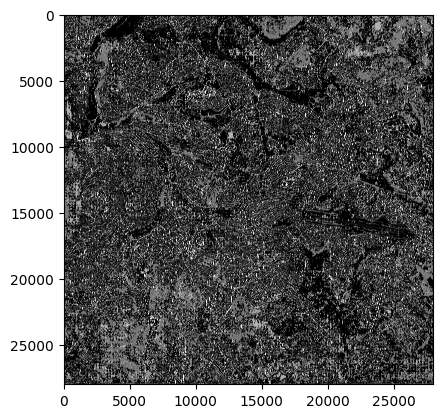

In [ ]:
merged_masks=rio.open('/content/drive/MyDrive/Colab Notebooks/merged_tiles/predicted_mask_II.tif')
plt.imshow(np.squeeze(merged_masks.read()),cmap='gray')
plt.show()

### End